In [2]:
import cobra
from cobra import Reaction, Metabolite
from cobra.io import read_sbml_model
from cobra.flux_analysis import production_envelope
import networkx as nx
import numpy as np
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
model = read_sbml_model('modified_iJN1463.xml')

ModuleNotFoundError: No module named 'scipy'

In [13]:
model

Name,iJN1463
Memory address,14f3875f230
Number of metabolites,2160
Number of reactions,2935
Number of genes,1462
Number of groups,0
Objective expression,1.0*BIOMASS_KT2440_WT3 - 1.0*BIOMASS_KT2440_WT3_reverse_d86d5
Compartments,"cytosol, extracellular space, periplasm"


In [14]:
model.reactions.EX_glc__D_e.lower_bound = 0  # 禁用葡萄糖
#model.reactions.EX_lac__D_e.lower_bound = 0  # 禁用乳酸
# 禁用其他不需要的碳源


def add_dynamic_bounds(model, y):
    """动态调整 TPA 和其他代谢物的摄取速率."""
    biomass, tpa = y  # 展开边界物种
    # 动态调整 TPA 的最大摄取速率
    tpa_max_import = -23.62 * tpa / (5 + tpa)  # 你可以调整这个公式
    model.reactions.EX_tpa_e.lower_bound = tpa_max_import
    

def dynamic_system(t, y):
    """计算外部物种的时间导数."""

    biomass, tpa = y  # 展开边界物种
    
    # 根据当前外部浓度计算具体的交换通量
    with model:
        add_dynamic_bounds(model, y)
        
        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        
        # 添加词典约束，最大化生物质和 TPA 摄取
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['BIOMASS_KT2440_WT3', 'EX_tpa_e'], ['max', 'max'])
    
    # 因为计算的通量是特定的速率，所以我们乘以生物质浓度来得到总的交换速率
    fluxes = lex_constraints.values
    fluxes *= biomass
    
    # 显示当前模拟时间（用于进度条）
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))
        
    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    确定解的可行性。
    
    使用 `solve_ivp` 的事件检测功能避免不可行的解。
    当该函数的符号从 -epsilon 变为正时，意味着解不再可行。
    """
    
    with model:
        add_dynamic_bounds(model, y)
        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        
    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

# 设置模拟时间和初始条件
ts = np.linspace(0, 5, 50)  # 模拟的时间范围
y0 = [0.1, 200]  # 初始生物质和 TPA 浓度

# 运行动态模拟
with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'  # 适合刚性系统的求解方法
    )

# 绘制生物质和 TPA 浓度随时间的变化
fig, ax1 = plt.subplots(figsize=(12, 8))

# 绘制生物质浓度
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Biomass', color='b')
ax1.plot(sol.t, sol.y.T[:, 0], label="Biomass", color='blue')
ax1.tick_params(axis='y', labelcolor='b')

# 创建第二个 y 轴来绘制 TPA 浓度
ax2 = ax1.twinx()
ax2.set_ylabel('TPA (mmol)', color='r')
ax2.plot(sol.t, sol.y.T[:, 1], label="TPA", color='red')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('dFBA Simulation: Biomass and TPA Concentration over Time')
plt.show()


NameError: name 'tqdm' is not defined

最先耗尽的代谢物为: EX_glc__D_e，在时间 0.00 小时.
碳源接近耗尽，模拟结束在时间 8.50 小时.
时间 8.50 小时，TPA 通量: -23.62, CO2 通量: 75.68376933953725, O2 通量: -89.18719061630584, H2O 通量: -0.01683497341423153, Biomass 通量: 0.6877734006426934


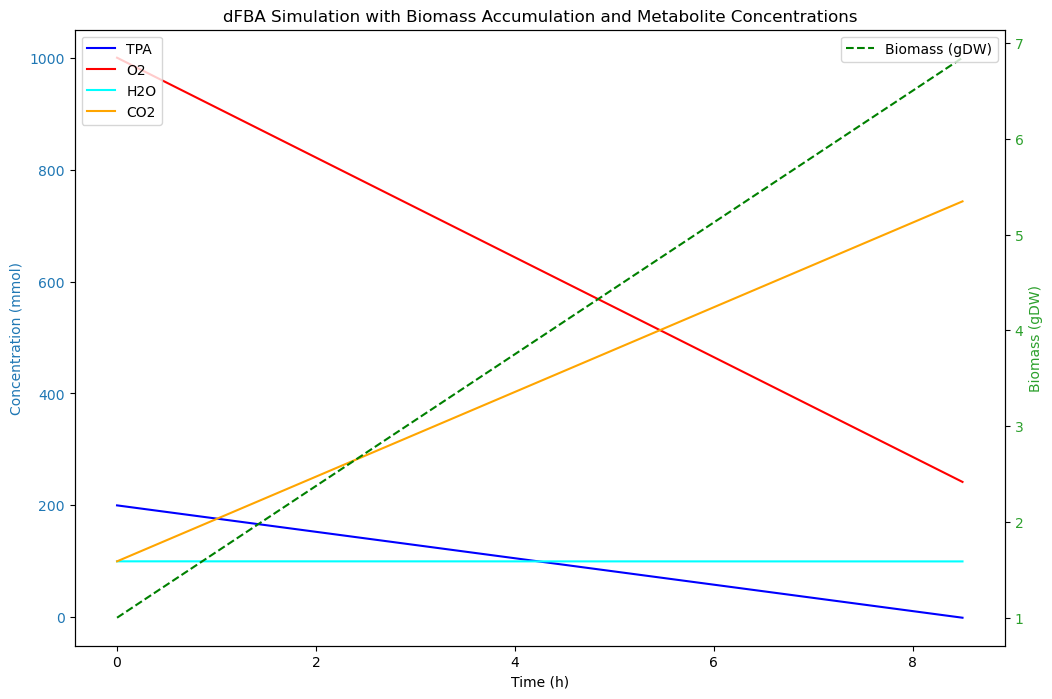

In [10]:
# 设置初始介质成分
initial_carbon = 200  # mmol
carbon_source = 'EX_tpa_e'  # 碳源 (TPA)
other_metabolites = {
    'EX_ca2_e': 100, 
    'EX_cl_e': 100, 
    'EX_cobalt2_e': 100, 
    'EX_cu2_e': 100,
    'EX_fe2_e': 100,
    'EX_glc__D_e':0,
    'EX_h_e': 100,
    'EX_k_e': 100,
    'EX_mg2_e': 100,
    'EX_mn2_e': 100,
    'EX_mobd_e': 100,
    'EX_na1_e': 100,
    'EX_nh4_e': 100,
    'EX_ni2_e': 100,
    'EX_o2_e': 1000,
    'EX_pi_e': 100,
    'EX_so4_e': 100,
    'EX_zn2_e': 100,
    'EX_h2o_e': 100,
    'EX_co2_e': 100,
    'EX_lrhh_e': 0
}

# 检查模型中是否有相应反应
if carbon_source not in model.reactions:
    raise ValueError(f"模型中没有碳源 '{carbon_source}' 对应的反应")
#model.reactions.get_by_id('EX_co2_e').lower_bound = 0    # 不允许摄取 CO2
#model.reactions.get_by_id('EX_co2_e').upper_bound = 1000 # 允许大量排放 CO2
#model.reactions.get_by_id('EX_tpa_e').lower_bound = -23.62  # TPA摄取
#model.reactions.get_by_id('EX_tpa_e').upper_bound = 0       # 不允许生成 TPA

#model.reactions.get_by_id('EX_o2_e').lower_bound = -1000    # O2 摄取
#model.reactions.get_by_id('EX_o2_e').upper_bound = 0        # 不允许生成 O2

# 设置时间步长和模拟时间
time_step = 0.1  # 小时
max_time = 10  # 最大模拟时间 (小时)
time_points = np.arange(0, max_time, time_step)

# 存储介质浓度和生物质用于绘图
concentration_data = {
    'time': [],
    'carbon': [],
    'O2': [],
    'H2O': [],
    'CO2': [],
    'biomass': [],
}

# 初始化浓度和生物质
current_carbon = initial_carbon
current_metabolites = other_metabolites.copy()
biomass_accumulation = 1
depleted_metabolite = None  # 存储最先耗尽的代谢物

for time in time_points:
    # 记录当前时间和浓度
    concentration_data['time'].append(time)
    concentration_data['carbon'].append(current_carbon)
    concentration_data['O2'].append(current_metabolites['EX_o2_e'])
    concentration_data['H2O'].append(current_metabolites['EX_h2o_e'])
    concentration_data['CO2'].append(current_metabolites['EX_co2_e'])
    concentration_data['biomass'].append(biomass_accumulation)
    
    # 检查碳源是否已耗尽
    if current_carbon < 0.01:
        print(f"碳源接近耗尽，模拟结束在时间 {time:.2f} 小时.")
        break

    # 设置模型中的培养基约束
    max_carbon_uptake = -23.62  # 设置最大碳源摄取速率
    model.reactions.get_by_id(carbon_source).lower_bound = max_carbon_uptake
    for metabolite, amount in current_metabolites.items():
        if metabolite in model.reactions:
            model.reactions.get_by_id(metabolite).lower_bound = -amount / time_step

    # 优化模型，计算通量
    model.objective = 'BIOMASS_KT2440_WT3' 
    solution = model.optimize()

    # 提取通量值，更新培养基浓度
    fluxes = solution.fluxes
    if carbon_source in fluxes:
        carbon_flux = fluxes[carbon_source]
        current_carbon += carbon_flux * time_step

    # 更新其他代谢物的浓度
    for metabolite in current_metabolites:
        if metabolite in fluxes:
            current_metabolites[metabolite] += fluxes[metabolite] * time_step
            if current_metabolites[metabolite] < 0:
                current_metabolites[metabolite] = 0  # 避免负值

        # 检查代谢物是否被耗尽
        if current_metabolites[metabolite] < 0.01 and depleted_metabolite is None:
            depleted_metabolite = metabolite
            print(f"最先耗尽的代谢物为: {depleted_metabolite}，在时间 {time:.2f} 小时.")
            
    # 记录生物质积累
    biomass_flux = fluxes.get('BIOMASS_KT2440_WT3', 0)
    biomass_accumulation += biomass_flux * time_step
    
# 打印 TPA、CO2、O2、H2O 的通量，确保方向正确
print(f"时间 {time:.2f} 小时，TPA 通量: {fluxes['EX_tpa_e']}, CO2 通量: {fluxes['EX_co2_e']}, O2 通量: {fluxes['EX_o2_e']}, H2O 通量: {fluxes['EX_h2o_e']}, Biomass 通量: {fluxes['BIOMASS_KT2440_WT3']}")

#print(concentration_data['carbon'])  # 检查 TPA 的浓度是否随时间减少
#print(concentration_data['CO2'])     # 检查 CO2 的浓度是否随时间增加

# 创建双 y 轴图
fig, ax1 = plt.subplots(figsize=(12, 8))

# 第一个 y 轴，显示代谢物浓度
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Concentration (mmol)', color='tab:blue')
ax1.plot(concentration_data['time'], concentration_data['carbon'], label="TPA", color='blue')
ax1.plot(concentration_data['time'], concentration_data['O2'], label="O2", color='red')
ax1.plot(concentration_data['time'], concentration_data['H2O'], label="H2O", color='cyan')
ax1.plot(concentration_data['time'], concentration_data['CO2'], label="CO2", color='orange')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc="upper left")

# 第二个 y 轴，显示生物质积累
ax2 = ax1.twinx()  # 创建共享x轴的第二个y轴
ax2.set_ylabel('Biomass (gDW)', color='tab:green')  # 设置第二个y轴的标签
ax2.plot(concentration_data['time'], concentration_data['biomass'], label="Biomass (gDW)", linestyle="--", color="green")
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc="upper right")

# 设置图的标题
plt.title('dFBA Simulation with Biomass Accumulation and Metabolite Concentrations')
plt.show()


最先耗尽的代谢物为: EX_glc__D_e，在时间 0.00 小时.
碳源接近耗尽，模拟结束在时间 8.50 小时.


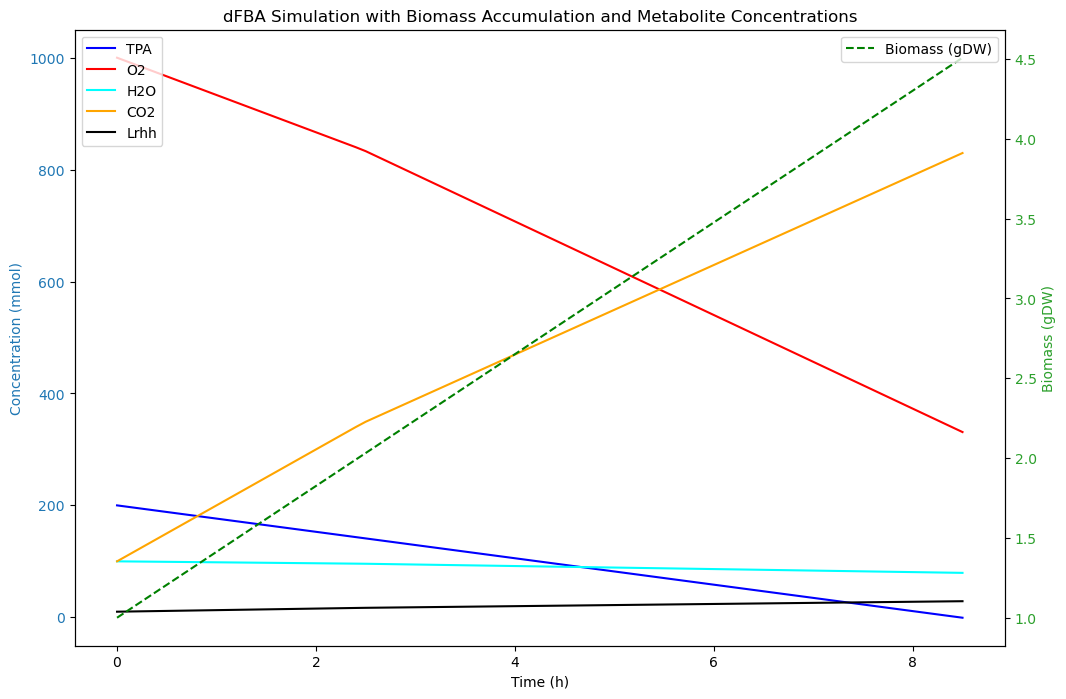

In [9]:
# 设置初始介质成分
initial_carbon = 200  # mmol
carbon_source = 'EX_tpa_e'  # 碳源 (TPA)
other_metabolites = {
    'EX_ca2_e': 100, 
    'EX_cl_e': 100, 
    'EX_cobalt2_e': 100, 
    'EX_cu2_e': 100,
    'EX_fe2_e': 100,
    'EX_glc__D_e':0,
    'EX_h_e': 100,
    'EX_k_e': 100,
    'EX_mg2_e': 100,
    'EX_mn2_e': 100,
    'EX_mobd_e': 100,
    'EX_na1_e': 100,
    'EX_nh4_e': 100,
    'EX_ni2_e': 100,
    'EX_o2_e': 1000,
    'EX_pi_e': 100,
    'EX_so4_e': 100,
    'EX_zn2_e': 100,
    'EX_h2o_e': 100,
    'EX_co2_e': 100,
    'EX_lrhh_e': 10
}

# 检查模型中是否有相应反应
if carbon_source not in model.reactions:
    raise ValueError(f"模型中没有碳源 '{carbon_source}' 对应的反应")
#model.reactions.get_by_id('EX_co2_e').lower_bound = 0    # 不允许摄取 CO2
#model.reactions.get_by_id('EX_co2_e').upper_bound = 1000 # 允许大量排放 CO2
#model.reactions.get_by_id('EX_tpa_e').lower_bound = -23.62  # TPA摄取
#model.reactions.get_by_id('EX_tpa_e').upper_bound = 0       # 不允许生成 TPA

#model.reactions.get_by_id('EX_o2_e').lower_bound = -1000    # O2 摄取
#model.reactions.get_by_id('EX_o2_e').upper_bound = 0        # 不允许生成 O2

# 设置时间步长和模拟时间
time_step = 0.1  # 小时
max_time = 10  # 最大模拟时间 (小时)
time_points = np.arange(0, max_time, time_step)

# 存储介质浓度和生物质用于绘图
concentration_data = {
    'time': [],
    'carbon': [],
    'O2': [],
    'H2O': [],
    'CO2': [],
    'Lrhh':[],
    'biomass': [],
}

# 初始化浓度和生物质
current_carbon = initial_carbon
current_metabolites = other_metabolites.copy()
biomass_accumulation = 1
depleted_metabolite = None  # 存储最先耗尽的代谢物

for time in time_points:
    # 记录当前时间和浓度
    concentration_data['time'].append(time)
    concentration_data['carbon'].append(current_carbon)
    concentration_data['O2'].append(current_metabolites['EX_o2_e'])
    concentration_data['H2O'].append(current_metabolites['EX_h2o_e'])
    concentration_data['CO2'].append(current_metabolites['EX_co2_e'])
    concentration_data['Lrhh'].append(current_metabolites['EX_lrhh_e'])
    concentration_data['biomass'].append(biomass_accumulation)
    
    # 检查碳源是否已耗尽
    if current_carbon < 0.01:
        print(f"碳源接近耗尽，模拟结束在时间 {time:.2f} 小时.")
        break

    # 设置模型中的培养基约束
    max_carbon_uptake = -23.62  # 设置最大碳源摄取速率
    model.reactions.get_by_id(carbon_source).lower_bound = max_carbon_uptake
    for metabolite, amount in current_metabolites.items():
        if metabolite in model.reactions:
            model.reactions.get_by_id(metabolite).lower_bound = -amount / time_step

    # 优化模型，计算通量
    #model.objective = 'BIOMASS_KT2440_WT3' 
    #solution = model.optimize()
    # 设定模型目标为生物质产量
    model.objective = model.reactions.BIOMASS_KT2440_WT3

    # 运行优化，得到最大生物质产量
    solution_biomass = model.optimize()

    # 锁定生物质产量在最大值
    biomass_max = solution_biomass.objective_value
    model.reactions.BIOMASS_KT2440_WT3.upper_bound = (biomass_max*1)
    model.reactions.BIOMASS_KT2440_WT3.lower_bound = (biomass_max*0.6)
    # 设定新的目标为最大化 RHLA 通量
    model.objective = model.reactions.RHLB

    # 运行优化
    solution_rhlb = model.optimize()
    #print("Biomass flux (fixed):", solution_rhla.fluxes['BIOMASS_KT2440_WT3'])
    #print("Optimized RHLB flux:", solution_rhla.fluxes['RHLB'])
    # 提取通量值，更新培养基浓度
    if carbon_source in solution_rhlb.fluxes:
        carbon_flux = solution_rhlb.fluxes[carbon_source]
        current_carbon += carbon_flux * time_step

    # 更新其他代谢物的浓度
    for metabolite in current_metabolites:
        if metabolite in solution_rhlb.fluxes:
            current_metabolites[metabolite] += solution_rhlb.fluxes[metabolite] * time_step
            if current_metabolites[metabolite] < 0:
                current_metabolites[metabolite] = 0  # 避免负值

        # 检查代谢物是否被耗尽
        if current_metabolites[metabolite] < 0.01 and depleted_metabolite is None:
            depleted_metabolite = metabolite
            print(f"最先耗尽的代谢物为: {depleted_metabolite}，在时间 {time:.2f} 小时.")
            
    # 记录生物质积累
    biomass_flux = solution_rhlb.fluxes.get('BIOMASS_KT2440_WT3', 0)
    biomass_accumulation += biomass_flux * time_step
    
# 打印 TPA、CO2、O2、H2O 的通量，确保方向正确
#print(f"时间 {time:.2f} 小时，TPA 通量: {fluxes['EX_tpa_e']}, CO2 通量: {fluxes['EX_co2_e']}, O2 通量: {fluxes['EX_o2_e']}, H2O 通量: {fluxes['EX_h2o_e']}, Biomass 通量: {fluxes['BIOMASS_KT2440_WT3']}")

#print(concentration_data['carbon'])  # 检查 TPA 的浓度是否随时间减少
#print(concentration_data['CO2'])     # 检查 CO2 的浓度是否随时间增加

# 创建双 y 轴图
fig, ax1 = plt.subplots(figsize=(12, 8))

# 第一个 y 轴，显示代谢物浓度
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Concentration (mmol)', color='tab:blue')
ax1.plot(concentration_data['time'], concentration_data['carbon'], label="TPA", color='blue')
ax1.plot(concentration_data['time'], concentration_data['O2'], label="O2", color='red')
ax1.plot(concentration_data['time'], concentration_data['H2O'], label="H2O", color='cyan')
ax1.plot(concentration_data['time'], concentration_data['CO2'], label="CO2", color='orange')
ax1.plot(concentration_data['time'], concentration_data['Lrhh'], label="Lrhh", color='black')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc="upper left")

# 第二个 y 轴，显示生物质积累
ax2 = ax1.twinx()  # 创建共享x轴的第二个y轴
ax2.set_ylabel('Biomass (gDW)', color='tab:green')  # 设置第二个y轴的标签
ax2.plot(concentration_data['time'], concentration_data['biomass'], label="Biomass (gDW)", linestyle="--", color="green")
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc="upper right")

# 设置图的标题
plt.title('dFBA Simulation with Biomass Accumulation and Metabolite Concentrations')
plt.show()


最先耗尽的代谢物为: EX_glc__D_e，在时间 0.00 小时.


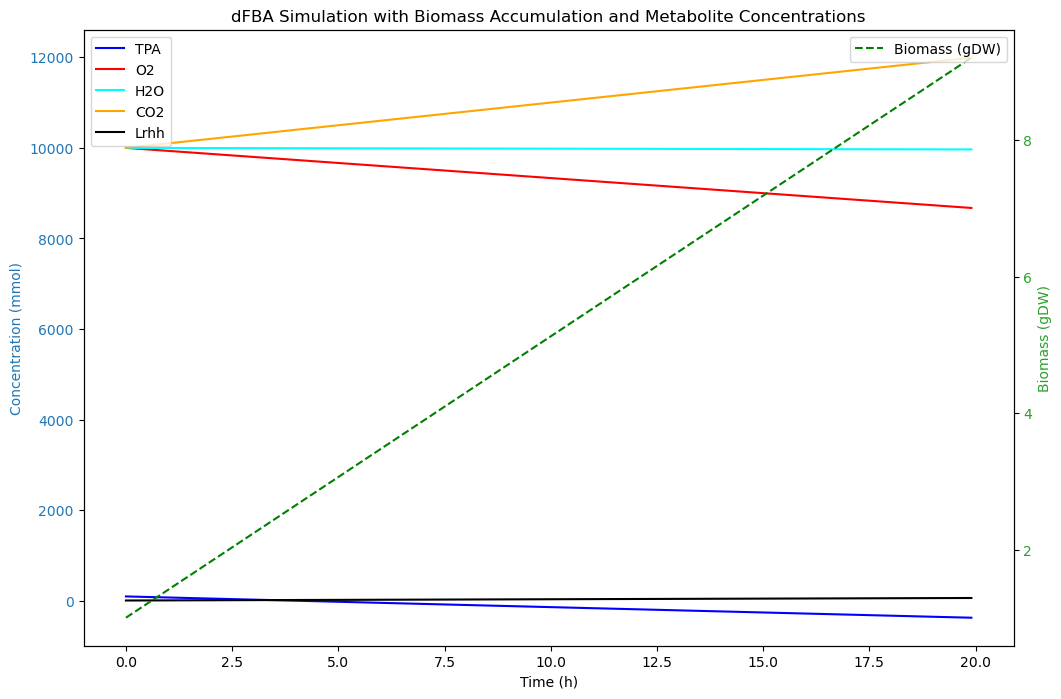

In [8]:
# 设置初始介质成分
initial_carbon = 100  # mmol
carbon_source = 'EX_tpa_e'  # 碳源 (TPA)
other_metabolites = {
    'EX_ca2_e': 1000, 
    'EX_cl_e': 1000, 
    'EX_cobalt2_e': 1000, 
    'EX_cu2_e': 1000,
    'EX_fe2_e': 1000,
    'EX_glc__D_e':0,
    'EX_h_e': 1000,
    'EX_k_e': 1000,
    'EX_mg2_e': 1000,
    'EX_mn2_e': 1000,
    'EX_mobd_e': 1000,
    'EX_na1_e': 1000,
    'EX_nh4_e': 1000,
    'EX_ni2_e': 1000,
    'EX_o2_e': 10000,
    'EX_pi_e': 1000,
    'EX_so4_e': 1000,
    'EX_zn2_e': 1000,
    'EX_h2o_e': 10000,
    'EX_co2_e': 10000,
    'EX_lrhh_e': 10
}

# 检查模型中是否有相应反应
if carbon_source not in model.reactions:
    raise ValueError(f"模型中没有碳源 '{carbon_source}' 对应的反应")
model.reactions.get_by_id('EX_co2_e').lower_bound = 0    # 不允许摄取 CO2
model.reactions.get_by_id('EX_co2_e').upper_bound = 1000 # 允许大量排放 CO2
model.reactions.get_by_id('EX_tpa_e').lower_bound = -23.62  # TPA摄取
model.reactions.get_by_id('EX_tpa_e').upper_bound = 0       # 不允许生成 TPA

model.reactions.get_by_id('EX_o2_e').lower_bound = -1000    # O2 摄取
model.reactions.get_by_id('EX_o2_e').upper_bound = 0        # 不允许生成 O2

# 设置时间步长和模拟时间
time_step = 0.1  # 小时
max_time = 20  # 最大模拟时间 (小时)
time_points = np.arange(0, max_time, time_step)

# 存储介质浓度和生物质用于绘图
concentration_data = {
    'time': [],
    'carbon': [],
    'O2': [],
    'H2O': [],
    'CO2': [],
    'Lrhh':[],
    'biomass': [],
}

# 初始化浓度和生物质
current_carbon = initial_carbon
current_metabolites = other_metabolites.copy()
biomass_accumulation = 1
depleted_metabolite = None  # 存储最先耗尽的代谢物

for time in time_points:
    # 记录当前时间和浓度
    concentration_data['time'].append(time)
    concentration_data['carbon'].append(current_carbon)
    concentration_data['O2'].append(current_metabolites['EX_o2_e'])
    concentration_data['H2O'].append(current_metabolites['EX_h2o_e'])
    concentration_data['CO2'].append(current_metabolites['EX_co2_e'])
    concentration_data['Lrhh'].append(current_metabolites['EX_lrhh_e'])
    concentration_data['biomass'].append(biomass_accumulation)
    
    # 检查碳源是否已耗尽
    #if current_carbon < 0.01:
     #   print(f"碳源接近耗尽，模拟结束在时间 {time:.2f} 小时.")
      #  break

    # 设置模型中的培养基约束
    max_carbon_uptake = -23.62  # 设置最大碳源摄取速率
    model.reactions.get_by_id(carbon_source).lower_bound = max_carbon_uptake
    for metabolite, amount in current_metabolites.items():
        if metabolite in model.reactions:
            model.reactions.get_by_id(metabolite).lower_bound = -amount / time_step

    # 优化模型，计算通量
    #model.objective = 'BIOMASS_KT2440_WT3' 
    #solution = model.optimize()
    # 设定模型目标为生物质产量
    model.objective = model.reactions.BIOMASS_KT2440_WT3

    # 运行优化，得到最大生物质产量
    solution_biomass = model.optimize()

    # 锁定生物质产量在最大值
    biomass_max = solution_biomass.objective_value
    model.reactions.BIOMASS_KT2440_WT3.upper_bound = (biomass_max*1)
    model.reactions.BIOMASS_KT2440_WT3.lower_bound = (biomass_max*0.6)
    # 设定新的目标为最大化 RHLA 通量
    model.objective = model.reactions.RHLB

    # 运行优化
    solution_rhlb = model.optimize()
    #print("Biomass flux (fixed):", solution_rhla.fluxes['BIOMASS_KT2440_WT3'])
    #print("Optimized RHLB flux:", solution_rhla.fluxes['RHLB'])
    # 提取通量值，更新培养基浓度
    if carbon_source in solution_rhlb.fluxes:
        carbon_flux = solution_rhlb.fluxes[carbon_source]
        current_carbon += carbon_flux * time_step

    # 更新其他代谢物的浓度
    for metabolite in current_metabolites:
        if metabolite in solution_rhlb.fluxes:
            current_metabolites[metabolite] += solution_rhlb.fluxes[metabolite] * time_step
            if current_metabolites[metabolite] < 0:
                current_metabolites[metabolite] = 0  # 避免负值

        # 检查代谢物是否被耗尽
        if current_metabolites[metabolite] < 0.01 and depleted_metabolite is None:
            depleted_metabolite = metabolite
            print(f"最先耗尽的代谢物为: {depleted_metabolite}，在时间 {time:.2f} 小时.")
            
    # 记录生物质积累
    biomass_flux = solution_rhlb.fluxes.get('BIOMASS_KT2440_WT3', 0)
    biomass_accumulation += biomass_flux * time_step
    
# 打印 TPA、CO2、O2、H2O 的通量，确保方向正确
#print(f"时间 {time:.2f} 小时，TPA 通量: {fluxes['EX_tpa_e']}, CO2 通量: {fluxes['EX_co2_e']}, O2 通量: {fluxes['EX_o2_e']}, H2O 通量: {fluxes['EX_h2o_e']}, Biomass 通量: {fluxes['BIOMASS_KT2440_WT3']}")

#print(concentration_data['carbon'])  # 检查 TPA 的浓度是否随时间减少
#print(concentration_data['CO2'])     # 检查 CO2 的浓度是否随时间增加

# 创建双 y 轴图
fig, ax1 = plt.subplots(figsize=(12, 8))

# 第一个 y 轴，显示代谢物浓度
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Concentration (mmol)', color='tab:blue')
ax1.plot(concentration_data['time'], concentration_data['carbon'], label="TPA", color='blue')
ax1.plot(concentration_data['time'], concentration_data['O2'], label="O2", color='red')
ax1.plot(concentration_data['time'], concentration_data['H2O'], label="H2O", color='cyan')
ax1.plot(concentration_data['time'], concentration_data['CO2'], label="CO2", color='orange')
ax1.plot(concentration_data['time'], concentration_data['Lrhh'], label="Lrhh", color='black')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc="upper left")

# 第二个 y 轴，显示生物质积累
ax2 = ax1.twinx()  # 创建共享x轴的第二个y轴
ax2.set_ylabel('Biomass (gDW)', color='tab:green')  # 设置第二个y轴的标签
ax2.plot(concentration_data['time'], concentration_data['biomass'], label="Biomass (gDW)", linestyle="--", color="green")
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc="upper right")

# 设置图的标题
plt.title('dFBA Simulation with Biomass Accumulation and Metabolite Concentrations')
plt.show()


In [28]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
h2o_e,EX_h2o_e,13.5,0,0.00%
o2_e,EX_o2_e,79.4,0,0.00%
tpa_e,EX_tpa_e,23.62,8,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-77.11,1,40.81%
lrhh_e,EX_lrhh_e,-2.585,26,35.56%
oxa_e,EX_oxa_e,-22.33,2,23.63%


最先耗尽的代谢物为: EX_glc__D_e，在时间 0.00 小时.
碳源接近耗尽，模拟结束在时间 8.70 小时.
时间 8.70 小时，TPA 通量: -13.40921352469587, CO2 通量: 59.67501482405336, O2 通量: -51.00675854203243, H2O 通量: 23.612203645827375, Biomass 通量: 1.1819671013647166


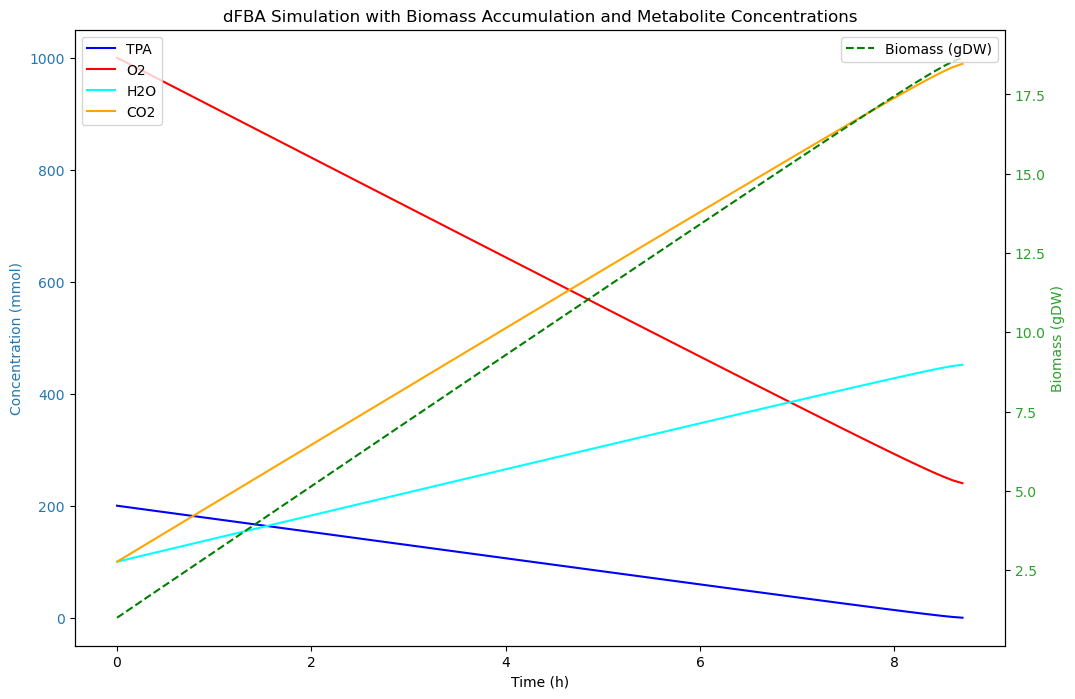

In [23]:
# 设置初始介质成分
initial_carbon = 200  # mmol
carbon_source = 'EX_tpa_e'  # 碳源 (TPA)
other_metabolites = {
    'EX_ca2_e': 100, 
    'EX_cl_e': 100, 
    'EX_cobalt2_e': 100, 
    'EX_cu2_e': 100,
    'EX_fe2_e': 100,
    'EX_glc__D_e':0,
    'EX_h_e': 100,
    'EX_k_e': 100,
    'EX_mg2_e': 100,
    'EX_mn2_e': 100,
    'EX_mobd_e': 100,
    'EX_na1_e': 100,
    'EX_nh4_e': 100,
    'EX_ni2_e': 100,
    'EX_o2_e': 1000,
    'EX_pi_e': 100,
    'EX_so4_e': 100,
    'EX_zn2_e': 100,
    'EX_h2o_e': 100,
    'EX_co2_e': 100,
}

# 检查模型中是否有相应反应
if carbon_source not in model.reactions:
    raise ValueError(f"模型中没有碳源 '{carbon_source}' 对应的反应")
model.reactions.get_by_id('EX_co2_e').lower_bound = 0    # 不允许摄取 CO2
model.reactions.get_by_id('EX_co2_e').upper_bound = 1000 # 允许大量排放 CO2
model.reactions.get_by_id('EX_tpa_e').lower_bound = -23.62  # TPA摄取
model.reactions.get_by_id('EX_tpa_e').upper_bound = 0       # 不允许生成 TPA

model.reactions.get_by_id('EX_o2_e').lower_bound = -1000    # O2 摄取
model.reactions.get_by_id('EX_o2_e').upper_bound = 0        # 不允许生成 O2

# 设置时间步长和模拟时间
time_step = 0.1  # 小时
max_time = 10  # 最大模拟时间 (小时)
time_points = np.arange(0, max_time, time_step)

# 存储介质浓度和生物质用于绘图
concentration_data = {
    'time': [],
    'carbon': [],
    'O2': [],
    'H2O': [],
    'CO2': [],
    'biomass': [],
}

# 初始化浓度和生物质
current_carbon = initial_carbon
current_metabolites = other_metabolites.copy()
biomass_accumulation = 1
depleted_metabolite = None  # 存储最先耗尽的代谢物

# 动态调整摄取速率的函数
def dynamic_uptake_rate(S, Vmax, Ks):
    return (Vmax * S) / (Ks + S)

# 设置最大摄取速率 (Vmax) 和半饱和常数 (Ks)
Vmax_glc = 6
Ks_glc = 0.5  # 假设葡萄糖的半饱和常数为0.5
Vmax_tpa = 23.62
Ks_tpa = 1.0  # 假设TPA的半饱和常数为1.0

# 模拟开始
for time in time_points:
    # 记录当前时间和浓度
    concentration_data['time'].append(time)
    concentration_data['carbon'].append(current_carbon)
    concentration_data['O2'].append(current_metabolites['EX_o2_e'])
    concentration_data['H2O'].append(current_metabolites['EX_h2o_e'])
    concentration_data['CO2'].append(current_metabolites['EX_co2_e'])
    concentration_data['biomass'].append(biomass_accumulation)
    
    # 检查碳源是否已耗尽
    if current_carbon < 0.01:
        print(f"碳源接近耗尽，模拟结束在时间 {time:.2f} 小时.")
        break

    # 根据浓度动态调整碳源摄取速率
    carbon_uptake = dynamic_uptake_rate(current_carbon, Vmax_tpa, Ks_tpa)
    glucose_uptake = dynamic_uptake_rate(current_metabolites['EX_glc__D_e'], Vmax_glc, Ks_glc)

    # 更新模型中的摄取速率
    model.reactions.get_by_id(carbon_source).lower_bound = -carbon_uptake
    model.reactions.get_by_id('EX_glc__D_e').lower_bound = -glucose_uptake
    model.reactions.get_by_id('EX_nh4_e').lower_bound = -28.72  # 设置氨摄取速率
    model.reactions.get_by_id('EX_pi_e').lower_bound = -2.482   # 设置磷酸盐摄取速率
    model.reactions.get_by_id('EX_o2_e').lower_bound = -100     # 设置氧气摄取速率
    
    # 设置其他微量代谢物的摄取速率
    model.reactions.get_by_id('EX_ca2_e').lower_bound = -0.0114
    model.reactions.get_by_id('EX_cl_e').lower_bound = -0.0114
    model.reactions.get_by_id('EX_cobalt2_e').lower_bound = -0.008202
    model.reactions.get_by_id('EX_cu2_e').lower_bound = -0.007601
    model.reactions.get_by_id('EX_fe2_e').lower_bound = -0.03963
    model.reactions.get_by_id('EX_k_e').lower_bound = -0.4277
    model.reactions.get_by_id('EX_mg2_e').lower_bound = -0.01901
    model.reactions.get_by_id('EX_mn2_e').lower_bound = -0.007601
    model.reactions.get_by_id('EX_mobd_e').lower_bound = -0.008804
    model.reactions.get_by_id('EX_na1_e').lower_bound = -0.009503
    model.reactions.get_by_id('EX_so4_e').lower_bound = -0.5018
    model.reactions.get_by_id('EX_zn2_e').lower_bound = -0.007601
    

    # 优化模型，计算通量
    model.objective = 'BIOMASS_KT2440_WT3' 
    solution = model.optimize()

    # 提取通量值，更新培养基浓度
    fluxes = solution.fluxes
    if carbon_source in fluxes:
        carbon_flux = fluxes[carbon_source]
        current_carbon += carbon_flux * time_step

    # 更新其他代谢物的浓度
    for metabolite in current_metabolites:
        if metabolite in fluxes:
            current_metabolites[metabolite] += fluxes[metabolite] * time_step
            if current_metabolites[metabolite] < 0:
                current_metabolites[metabolite] = 0  # 避免负值

        # 检查代谢物是否被耗尽
        if current_metabolites[metabolite] < 0.01 and depleted_metabolite is None:
            depleted_metabolite = metabolite
            print(f"最先耗尽的代谢物为: {depleted_metabolite}，在时间 {time:.2f} 小时.")
            
    # 记录生物质积累
    biomass_flux = fluxes.get('BIOMASS_KT2440_WT3', 0)
    biomass_accumulation += biomass_flux * time_step
    
# 打印 TPA、CO2、O2、H2O 的通量，确保方向正确
print(f"时间 {time:.2f} 小时，TPA 通量: {fluxes['EX_tpa_e']}, CO2 通量: {fluxes['EX_co2_e']}, O2 通量: {fluxes['EX_o2_e']}, H2O 通量: {fluxes['EX_h2o_e']}, Biomass 通量: {fluxes['BIOMASS_KT2440_WT3']}")

#print(concentration_data['carbon'])  # 检查 TPA 的浓度是否随时间减少
#print(concentration_data['CO2'])     # 检查 CO2 的浓度是否随时间增加

# 创建双 y 轴图
fig, ax1 = plt.subplots(figsize=(12, 8))

# 第一个 y 轴，显示代谢物浓度
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Concentration (mmol)', color='tab:blue')
ax1.plot(concentration_data['time'], concentration_data['carbon'], label="TPA", color='blue')
ax1.plot(concentration_data['time'], concentration_data['O2'], label="O2", color='red')
ax1.plot(concentration_data['time'], concentration_data['H2O'], label="H2O", color='cyan')
ax1.plot(concentration_data['time'], concentration_data['CO2'], label="CO2", color='orange')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc="upper left")

# 第二个 y 轴，显示生物质积累
ax2 = ax1.twinx()  # 创建共享x轴的第二个y轴
ax2.set_ylabel('Biomass (gDW)', color='tab:green')  # 设置第二个y轴的标签
ax2.plot(concentration_data['time'], concentration_data['biomass'], label="Biomass (gDW)", linestyle="--", color="green")
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc="upper right")

# 设置图的标题
plt.title('dFBA Simulation with Biomass Accumulation and Metabolite Concentrations')
plt.show()


最先耗尽的代谢物为: EX_nh4_e，在时间 3.50 小时.
碳源接近耗尽，模拟结束在时间 8.70 小时.
时间 8.70 小时，TPA 通量: -13.40921352469587, CO2 通量: 70.66217121236082, O2 通量: -61.0376613292286, H2O 通量: 49.68751617050135, Biomass 通量: 1.7575587666550194


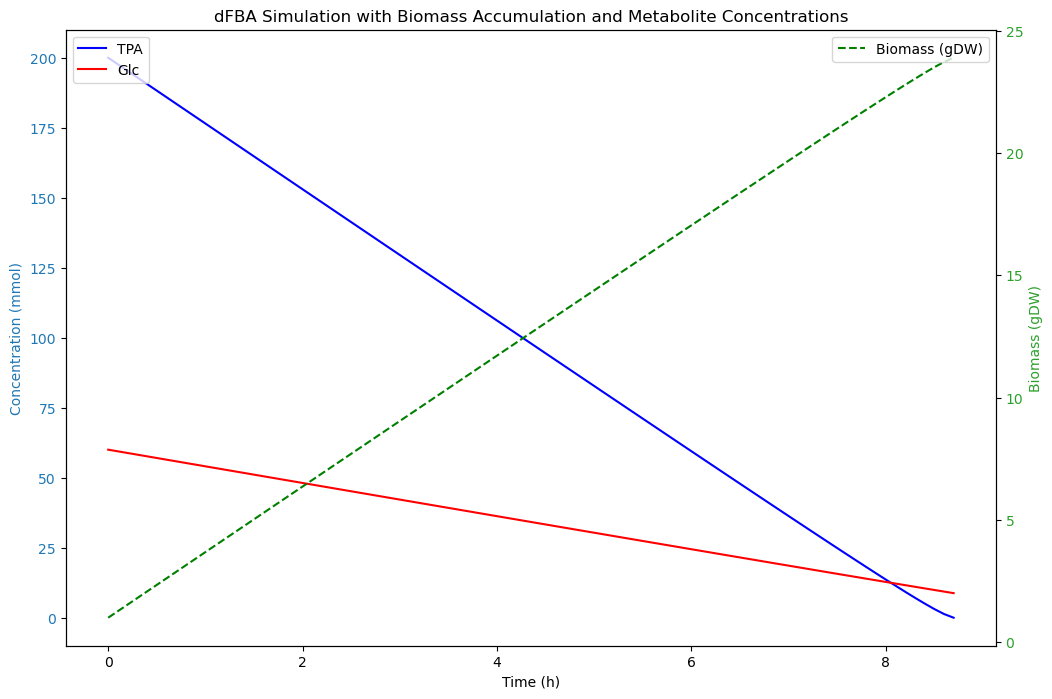

In [29]:
# 设置初始介质成分
initial_carbon = 200  # mmol
carbon_source = 'EX_tpa_e'  # 碳源 (TPA)
other_metabolites = {
    'EX_ca2_e': 100, 
    'EX_cl_e': 100, 
    'EX_cobalt2_e': 100, 
    'EX_cu2_e': 100,
    'EX_fe2_e': 100,
    'EX_glc__D_e': 60,   
    'EX_h_e': 100,
    'EX_k_e': 100,
    'EX_mg2_e': 100,
    'EX_mn2_e': 100,
    'EX_mobd_e': 100,
    'EX_na1_e': 100,
    'EX_nh4_e': 100,  
    'EX_ni2_e': 100,
    'EX_o2_e': 10000,    
    'EX_pi_e': 100,   
    'EX_so4_e': 100,
    'EX_zn2_e': 100,
    'EX_h2o_e': 100,
    'EX_co2_e': 100,
}

# 检查模型中是否有相应反应
if carbon_source not in model.reactions:
    raise ValueError(f"模型中没有碳源 '{carbon_source}' 对应的反应")

# 设置时间步长和模拟时间
time_step = 0.1  # 小时
max_time = 24  # 最大模拟时间 (小时)
time_points = np.arange(0, max_time, time_step)

# 存储介质浓度和生物质用于绘图
concentration_data = {
    'time': [],
    'carbon': [],
    'O2': [],
    'Glc':[],
    'H2O': [],
    'CO2': [],
    'biomass': [],
}

# 初始化浓度和生物质
current_carbon = initial_carbon
current_metabolites = other_metabolites.copy()
biomass_accumulation = 1
depleted_metabolite = None  # 存储最先耗尽的代谢物

# 动态调整摄取速率的函数
def dynamic_uptake_rate(S, Vmax, Ks):
    return (Vmax * S) / (Ks + S)

# 设置最大摄取速率 (Vmax) 和半饱和常数 (Ks)
Vmax_glc = 6
Ks_glc = 0.5  # 假设葡萄糖的半饱和常数为0.5
Vmax_tpa = 23.62
Ks_tpa = 1.0  # 假设TPA的半饱和常数为1.0

# 模拟开始
for time in time_points:
    # 记录当前时间和浓度
    concentration_data['time'].append(time)
    concentration_data['carbon'].append(current_carbon)
    concentration_data['O2'].append(current_metabolites['EX_o2_e'])
    concentration_data['Glc'].append(current_metabolites['EX_glc__D_e'])
    concentration_data['H2O'].append(current_metabolites['EX_h2o_e'])
    concentration_data['CO2'].append(current_metabolites['EX_co2_e'])
    concentration_data['biomass'].append(biomass_accumulation)
    
    # 检查碳源是否已耗尽
    if current_carbon < 0.01:
        print(f"碳源接近耗尽，模拟结束在时间 {time:.2f} 小时.")
        break

    # 根据浓度动态调整碳源摄取速率
    carbon_uptake = dynamic_uptake_rate(current_carbon, Vmax_tpa, Ks_tpa)
    glucose_uptake = dynamic_uptake_rate(current_metabolites['EX_glc__D_e'], Vmax_glc, Ks_glc)

    # 更新模型中的摄取速率
    model.reactions.get_by_id(carbon_source).lower_bound = -carbon_uptake
    model.reactions.get_by_id('EX_glc__D_e').lower_bound = -glucose_uptake
    model.reactions.get_by_id('EX_nh4_e').lower_bound = -28.72  # 设置氨摄取速率
    model.reactions.get_by_id('EX_pi_e').lower_bound = -2.482   # 设置磷酸盐摄取速率
    model.reactions.get_by_id('EX_o2_e').lower_bound = -100     # 设置氧气摄取速率
    
    # 设置其他微量代谢物的摄取速率
    model.reactions.get_by_id('EX_ca2_e').lower_bound = -0.0114
    model.reactions.get_by_id('EX_cl_e').lower_bound = -0.0114
    model.reactions.get_by_id('EX_cobalt2_e').lower_bound = -0.008202
    model.reactions.get_by_id('EX_cu2_e').lower_bound = -0.007601
    model.reactions.get_by_id('EX_fe2_e').lower_bound = -0.03963
    model.reactions.get_by_id('EX_k_e').lower_bound = -0.4277
    model.reactions.get_by_id('EX_mg2_e').lower_bound = -0.01901
    model.reactions.get_by_id('EX_mn2_e').lower_bound = -0.007601
    model.reactions.get_by_id('EX_mobd_e').lower_bound = -0.008804
    model.reactions.get_by_id('EX_na1_e').lower_bound = -0.009503
    model.reactions.get_by_id('EX_so4_e').lower_bound = -0.5018
    model.reactions.get_by_id('EX_zn2_e').lower_bound = -0.007601
    
    # 优化模型，计算通量
    model.objective = 'BIOMASS_KT2440_WT3' 
    solution = model.optimize()

    # 提取通量值，更新培养基浓度
    fluxes = solution.fluxes
    if carbon_source in fluxes:
        carbon_flux = fluxes[carbon_source]
        current_carbon += carbon_flux * time_step

    # 更新其他代谢物的浓度
    for metabolite in current_metabolites:
        if metabolite in fluxes:
            current_metabolites[metabolite] += fluxes[metabolite] * time_step
            if current_metabolites[metabolite] < 0:
                current_metabolites[metabolite] = 0  # 避免负值

        # 检查代谢物是否被耗尽
        if current_metabolites[metabolite] < 0.01 and depleted_metabolite is None:
            depleted_metabolite = metabolite
            print(f"最先耗尽的代谢物为: {depleted_metabolite}，在时间 {time:.2f} 小时.")
            
    # 记录生物质积累
    biomass_flux = fluxes.get('BIOMASS_KT2440_WT3', 0)
    biomass_accumulation += biomass_flux * time_step
    
# 打印 TPA、CO2、O2、H2O 的通量，确保方向正确
print(f"时间 {time:.2f} 小时，TPA 通量: {fluxes['EX_tpa_e']}, CO2 通量: {fluxes['EX_co2_e']}, O2 通量: {fluxes['EX_o2_e']}, H2O 通量: {fluxes['EX_h2o_e']}, Biomass 通量: {fluxes['BIOMASS_KT2440_WT3']}")

# 创建双 y 轴图
fig, ax1 = plt.subplots(figsize=(12, 8))

# 第一个 y 轴，显示代谢物浓度
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Concentration (mmol)', color='tab:blue')
ax1.plot(concentration_data['time'], concentration_data['carbon'], label="TPA", color='blue')
#ax1.plot(concentration_data['time'], concentration_data['O2'], label="O2", color='red')
ax1.plot(concentration_data['time'], concentration_data['Glc'], label="Glc", color='red')
#ax1.plot(concentration_data['time'], concentration_data['H2O'], label="H2O", color='cyan')
#ax1.plot(concentration_data['time'], concentration_data['CO2'], label="CO2", color='orange')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc="upper left")

# 第二个 y 轴，显示生物质积累
ax2 = ax1.twinx()  # 创建共享x轴的第二个y轴
ax2.set_ylabel('Biomass (gDW)', color='tab:green')  # 设置第二个y轴的标签
ax2.plot(concentration_data['time'], concentration_data['biomass'], label="Biomass (gDW)", linestyle="--", color="green")
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc="upper right")

# 设置图的标题
plt.title('dFBA Simulation with Biomass Accumulation and Metabolite Concentrations')
plt.show()


最先耗尽的代谢物为: EX_glc__D_e，在时间 0.00 小时.
碳源接近耗尽，模拟结束在时间 9.10 小时.
时间 9.10 小时，TPA 通量: -22.17489327353386, CO2 通量: 98.9171413007702, O2 通量: -100.0, H2O 通量: 59.457246370666894, Biomass 通量: 2.313193083452599


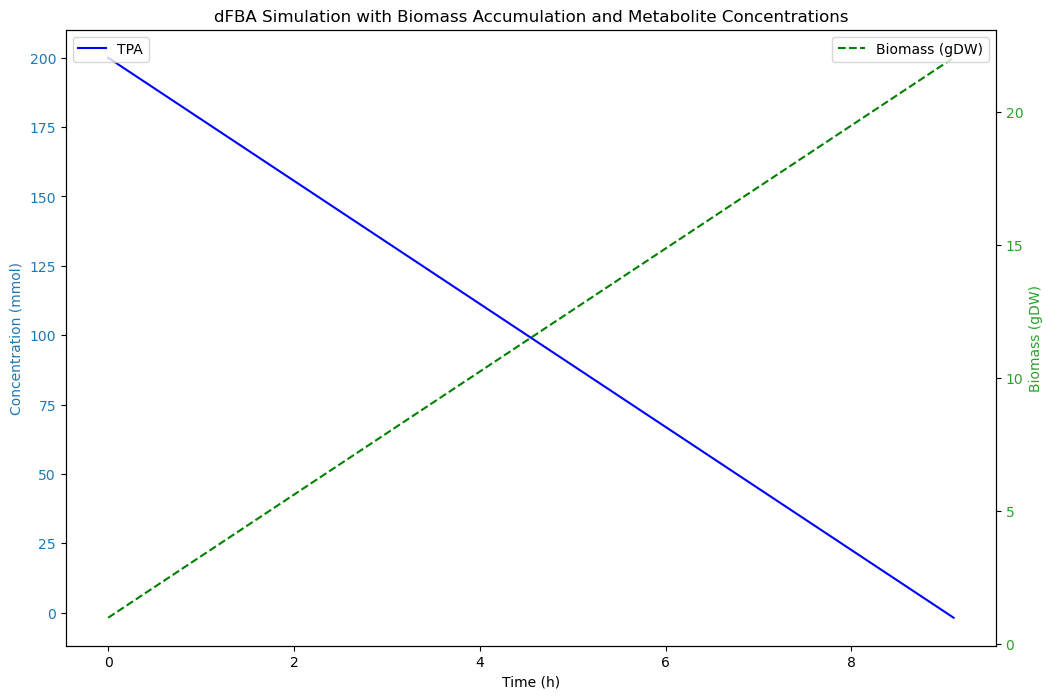

In [10]:
# 设置初始介质成分
initial_carbon = 200  # mmol
carbon_source = 'EX_tpa_e'  # 碳源 (TPA)
other_metabolites = {
    'EX_ca2_e': 100, 
    'EX_cl_e': 100, 
    'EX_cobalt2_e': 100, 
    'EX_cu2_e': 100,
    'EX_fe2_e': 100,
    'EX_glc__D_e': 0,   
    'EX_h_e': 100,
    'EX_k_e': 100,
    'EX_mg2_e': 100,
    'EX_mn2_e': 100,
    'EX_mobd_e': 100,
    'EX_na1_e': 100,
    'EX_nh4_e': 100,  
    'EX_ni2_e': 100,
    'EX_o2_e': 10000,    
    'EX_pi_e': 100,   
    'EX_so4_e': 100,
    'EX_zn2_e': 100,
    'EX_h2o_e': 100,
    'EX_co2_e': 100,
}

# 检查模型中是否有相应反应
if carbon_source not in model.reactions:
    raise ValueError(f"模型中没有碳源 '{carbon_source}' 对应的反应")

# 设置时间步长和模拟时间
time_step = 0.1  # 小时
max_time = 24  # 最大模拟时间 (小时)
time_points = np.arange(0, max_time, time_step)

# 存储介质浓度和生物质用于绘图
concentration_data = {
    'time': [],
    'carbon': [],
    'O2': [],
    'H2O': [],
    'CO2': [],
    'biomass': [],
}

# 初始化浓度和生物质
current_carbon = initial_carbon
current_metabolites = other_metabolites.copy()
biomass_accumulation = 1
depleted_metabolite = None  # 存储最先耗尽的代谢物

for time in time_points:
    # 记录当前时间和浓度
    concentration_data['time'].append(time)
    concentration_data['carbon'].append(current_carbon)
    concentration_data['O2'].append(current_metabolites['EX_o2_e'])
    concentration_data['H2O'].append(current_metabolites['EX_h2o_e'])
    concentration_data['CO2'].append(current_metabolites['EX_co2_e'])
    concentration_data['biomass'].append(biomass_accumulation)
    
    # 检查碳源是否已耗尽
    if current_carbon < 0.01:
        print(f"碳源接近耗尽，模拟结束在时间 {time:.2f} 小时.")
        break

    # 设置模型中的培养基约束
    max_carbon_uptake = -23.62  # 设置最大碳源摄取速率
    model.reactions.get_by_id(carbon_source).lower_bound = max_carbon_uptake
    model.reactions.get_by_id('EX_glc__D_e').lower_bound = -6  # 设置葡萄糖摄取速率
    model.reactions.get_by_id('EX_nh4_e').lower_bound = -28.72  # 设置氨摄取速率
    model.reactions.get_by_id('EX_pi_e').lower_bound = -2.482   # 设置磷酸盐摄取速率
    model.reactions.get_by_id('EX_o2_e').lower_bound = -100     # 设置氧气摄取速率
    
    # 设置其他微量代谢物的摄取速率
    model.reactions.get_by_id('EX_ca2_e').lower_bound = -0.0114
    model.reactions.get_by_id('EX_cl_e').lower_bound = -0.0114
    model.reactions.get_by_id('EX_cobalt2_e').lower_bound = -0.008202
    model.reactions.get_by_id('EX_cu2_e').lower_bound = -0.007601
    model.reactions.get_by_id('EX_fe2_e').lower_bound = -0.03963
    model.reactions.get_by_id('EX_k_e').lower_bound = -0.4277
    model.reactions.get_by_id('EX_mg2_e').lower_bound = -0.01901
    model.reactions.get_by_id('EX_mn2_e').lower_bound = -0.007601
    model.reactions.get_by_id('EX_mobd_e').lower_bound = -0.008804
    model.reactions.get_by_id('EX_na1_e').lower_bound = -0.009503
    model.reactions.get_by_id('EX_so4_e').lower_bound = -0.5018
    model.reactions.get_by_id('EX_zn2_e').lower_bound = -0.007601

    # 优化模型，计算通量
    model.objective = 'BIOMASS_KT2440_WT3' 
    solution = model.optimize()

    # 提取通量值，更新培养基浓度
    fluxes = solution.fluxes
    if carbon_source in fluxes:
        carbon_flux = fluxes[carbon_source]
        current_carbon += carbon_flux * time_step

    # 更新其他代谢物的浓度
    for metabolite in current_metabolites:
        if metabolite in fluxes:
            current_metabolites[metabolite] += fluxes[metabolite] * time_step
            if current_metabolites[metabolite] < 0:
                current_metabolites[metabolite] = 0  # 避免负值

        # 检查代谢物是否被耗尽
        if current_metabolites[metabolite] < 0.01 and depleted_metabolite is None:
            depleted_metabolite = metabolite
            print(f"最先耗尽的代谢物为: {depleted_metabolite}，在时间 {time:.2f} 小时.")
            
    # 记录生物质积累
    biomass_flux = fluxes.get('BIOMASS_KT2440_WT3', 0)
    biomass_accumulation += biomass_flux * time_step
    
# 打印 TPA、CO2、O2、H2O 的通量，确保方向正确
print(f"时间 {time:.2f} 小时，TPA 通量: {fluxes['EX_tpa_e']}, CO2 通量: {fluxes['EX_co2_e']}, O2 通量: {fluxes['EX_o2_e']}, H2O 通量: {fluxes['EX_h2o_e']}, Biomass 通量: {fluxes['BIOMASS_KT2440_WT3']}")

# 创建双 y 轴图
fig, ax1 = plt.subplots(figsize=(12, 8))

# 第一个 y 轴，显示代谢物浓度
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Concentration (mmol)', color='tab:blue')
ax1.plot(concentration_data['time'], concentration_data['carbon'], label="TPA", color='blue')
#ax1.plot(concentration_data['time'], concentration_data['O2'], label="O2", color='red')
#ax1.plot(concentration_data['time'], concentration_data['H2O'], label="H2O", color='cyan')
#ax1.plot(concentration_data['time'], concentration_data['CO2'], label="CO2", color='orange')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc="upper left")

# 第二个 y 轴，显示生物质积累
ax2 = ax1.twinx()  # 创建共享x轴的第二个y轴
ax2.set_ylabel('Biomass (gDW)', color='tab:green')  # 设置第二个y轴的标签
ax2.plot(concentration_data['time'], concentration_data['biomass'], label="Biomass (gDW)", linestyle="--", color="green")
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc="upper right")

# 设置图的标题
plt.title('dFBA Simulation with Biomass Accumulation and Metabolite Concentrations')
plt.show()


In [8]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.009776,0,0.00%
cl_e,EX_cl_e,0.009776,0,0.00%
cobalt2_e,EX_cobalt2_e,0.007032,0,0.00%
cu2_e,EX_cu2_e,0.006516,0,0.00%
fe2_e,EX_fe2_e,0.03397,0,0.00%
glc__D_e,EX_glc__D_e,6,6,16.87%
k_e,EX_k_e,0.3667,0,0.00%
mg2_e,EX_mg2_e,0.01629,0,0.00%
mn2_e,EX_mn2_e,0.006516,0,0.00%
mobd_e,EX_mobd_e,0.007548,0,0.00%


最先耗尽的代谢物为: EX_glc__D_e，在时间 0.00 小时.
碳源接近耗尽，模拟结束在时间 8.50 小时.
时间 8.50 小时，TPA 通量: -23.62, CO2 通量: 82.67000000000004, O2 通量: -110.2920598377312, H2O 通量: 1.4942985598421565, Biomass 通量: -3.2874936106876298e-15


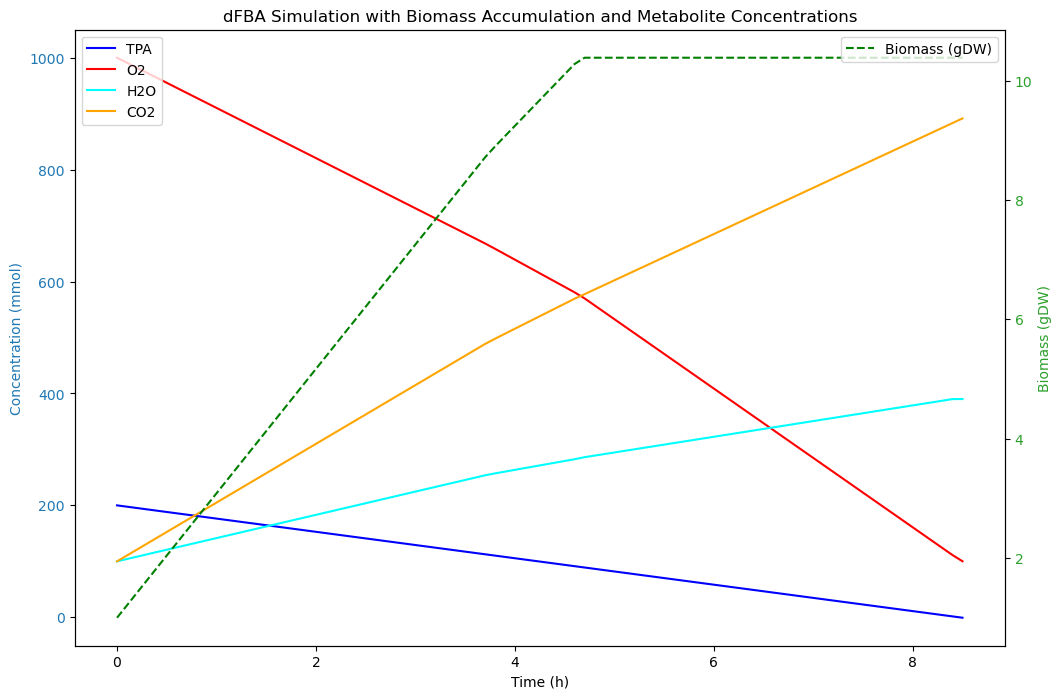

In [3]:
# 设置初始介质成分
initial_carbon = 200  # mmol
carbon_source = 'EX_tpa_e'  # 碳源 (TPA)
other_metabolites = {
    'EX_ca2_e': 100, 
    'EX_cl_e': 100, 
    'EX_cobalt2_e': 100, 
    'EX_cu2_e': 100,
    'EX_fe2_e': 100,
    'EX_glc__D_e':0,
    'EX_h_e': 100,
    'EX_k_e': 100,
    'EX_mg2_e': 100,
    'EX_mn2_e': 100,
    'EX_mobd_e': 100,
    'EX_na1_e': 100,
    'EX_nh4_e': 100,
    'EX_ni2_e': 100,
    'EX_o2_e': 1000,
    'EX_pi_e': 100,
    'EX_so4_e': 100,
    'EX_zn2_e': 100,
    'EX_h2o_e': 100,
    'EX_co2_e': 100,
}

# 检查模型中是否有相应反应
if carbon_source not in model.reactions:
    raise ValueError(f"模型中没有碳源 '{carbon_source}' 对应的反应")

# 设置时间步长和模拟时间
time_step = 0.1  # 小时
max_time = 10  # 最大模拟时间 (小时)
time_points = np.arange(0, max_time, time_step)

# 存储介质浓度和生物质用于绘图
concentration_data = {
    'time': [],
    'carbon': [],
    'O2': [],
    'H2O': [],
    'CO2': [],
    'biomass': [],
}

# 初始化浓度和生物质
current_carbon = initial_carbon
current_metabolites = other_metabolites.copy()
biomass_accumulation = 1
depleted_metabolite = None  # 存储最先耗尽的代谢物

for time in time_points:
    # 记录当前时间和浓度
    concentration_data['time'].append(time)
    concentration_data['carbon'].append(current_carbon)
    concentration_data['O2'].append(current_metabolites['EX_o2_e'])
    concentration_data['H2O'].append(current_metabolites['EX_h2o_e'])
    concentration_data['CO2'].append(current_metabolites['EX_co2_e'])
    concentration_data['biomass'].append(biomass_accumulation)
    
    # 检查碳源是否已耗尽
    if current_carbon < 0.01:
        print(f"碳源接近耗尽，模拟结束在时间 {time:.2f} 小时.")
        break

    # 设置模型中的培养基约束
    max_carbon_uptake = -23.62  # 设置最大碳源摄取速率
    model.reactions.get_by_id(carbon_source).lower_bound = max_carbon_uptake
    for metabolite, amount in current_metabolites.items():
        if metabolite in model.reactions:
            model.reactions.get_by_id(metabolite).lower_bound = -amount / time_step

    # 优化模型，计算通量
    model.objective = 'BIOMASS_KT2440_WT3' 
    solution = model.optimize()

    # 提取通量值，更新培养基浓度
    fluxes = solution.fluxes
    if carbon_source in fluxes:
        carbon_flux = fluxes[carbon_source]
        current_carbon += carbon_flux * time_step

    # 更新其他代谢物的浓度
    for metabolite in current_metabolites:
        if metabolite in fluxes:
            current_metabolites[metabolite] += fluxes[metabolite] * time_step
            if current_metabolites[metabolite] < 0:
                current_metabolites[metabolite] = 0  # 避免负值

        # 检查代谢物是否被耗尽
        if current_metabolites[metabolite] < 0.01 and depleted_metabolite is None:
            depleted_metabolite = metabolite
            print(f"最先耗尽的代谢物为: {depleted_metabolite}，在时间 {time:.2f} 小时.")
            
    # 记录生物质积累
    biomass_flux = fluxes.get('BIOMASS_KT2440_WT3', 0)
    biomass_accumulation += biomass_flux * time_step
    
# 打印 TPA、CO2、O2、H2O 的通量，确保方向正确
print(f"时间 {time:.2f} 小时，TPA 通量: {fluxes['EX_tpa_e']}, CO2 通量: {fluxes['EX_co2_e']}, O2 通量: {fluxes['EX_o2_e']}, H2O 通量: {fluxes['EX_h2o_e']}, Biomass 通量: {fluxes['BIOMASS_KT2440_WT3']}")

#print(concentration_data['carbon'])  # 检查 TPA 的浓度是否随时间减少
#print(concentration_data['CO2'])     # 检查 CO2 的浓度是否随时间增加

# 创建双 y 轴图
fig, ax1 = plt.subplots(figsize=(12, 8))

# 第一个 y 轴，显示代谢物浓度
ax1.set_xlabel('Time (h)')
ax1.set_ylabel('Concentration (mmol)', color='tab:blue')
ax1.plot(concentration_data['time'], concentration_data['carbon'], label="TPA", color='blue')
ax1.plot(concentration_data['time'], concentration_data['O2'], label="O2", color='red')
ax1.plot(concentration_data['time'], concentration_data['H2O'], label="H2O", color='cyan')
ax1.plot(concentration_data['time'], concentration_data['CO2'], label="CO2", color='orange')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc="upper left")

# 第二个 y 轴，显示生物质积累
ax2 = ax1.twinx()  # 创建共享x轴的第二个y轴
ax2.set_ylabel('Biomass (gDW)', color='tab:green')  # 设置第二个y轴的标签
ax2.plot(concentration_data['time'], concentration_data['biomass'], label="Biomass (gDW)", linestyle="--", color="green")
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc="upper right")

# 设置图的标题
plt.title('dFBA Simulation with Biomass Accumulation and Metabolite Concentrations')
plt.show()


In [4]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
o2_e,EX_o2_e,0.4519,0,0.00%
tpa_e,EX_tpa_e,0.06456,8,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-0.3874,1,75.00%
h2o_e,EX_h2o_e,-0.1291,0,0.00%
oxa_e,EX_oxa_e,-0.06456,2,25.00%


最先耗尽的代谢物为: EX_co2_e，在时间 0.00 小时.
其他代谢物耗尽，模拟结束在时间 0.00 小时.
最先耗尽的代谢物是 EX_co2_e


C:\Users\15083\.conda\envs\jupyter\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27987 (\N{CJK UNIFIED IDEOGRAPH-6D53}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\15083\.conda\envs\jupyter\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\15083\.conda\envs\jupyter\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\15083\.conda\envs\jupyter\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25311 (\N{CJK UNIFIED IDEOGRAPH-62DF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\15083\.conda\envs\jupyter\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22521 (\N{CJK UNIFIE

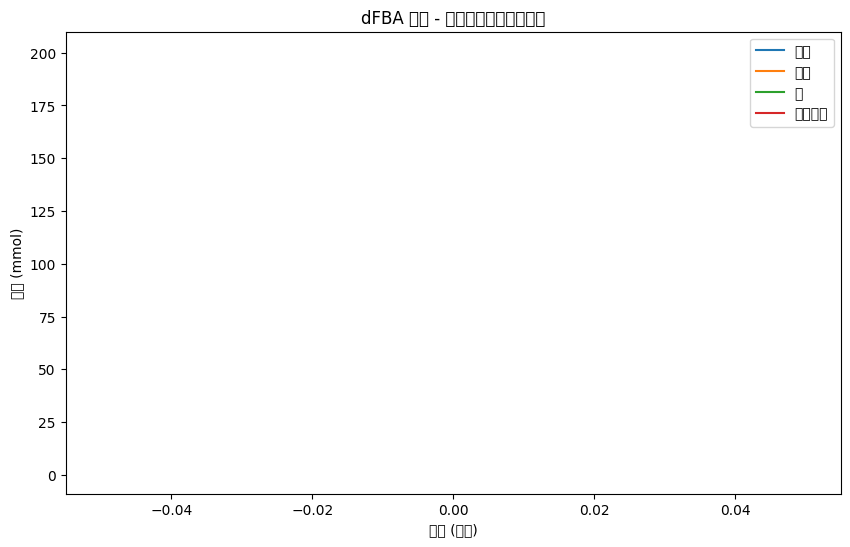

In [14]:

# 设置初始介质成分
initial_carbon = 200  # mmol
carbon_source = 'EX_tpa_e'  # 碳源 (TPA)
other_metabolites = {
    'EX_ca2_e': 1, 
    'EX_cl_e': 1, 
    'EX_cobalt2_e': 1, 
    'EX_cu2_e': 1,
    'EX_fe2_e': 1,
    'EX_glc_D_e': 0,
    'EX_h_e': 10,
    'EX_k_e': 1,
    'EX_mg2_e': 1,
    'EX_mn2_e': 1,
    'EX_mobd_e': 1,
    'EX_na1_e': 1,
    'EX_nh4_e': 10,
    'EX_ni2_e': 1,
    'EX_o2_e': 100,
    'EX_pi_e': 1,
    'EX_so4_e': 1,
    'EX_zn2_e': 1,
    'EX_h2o_e': 100,
    'EX_co2_e': 1,
}

# 检查模型中是否有相应反应
if carbon_source not in model.reactions:
    raise ValueError(f"模型中没有碳源 '{carbon_source}' 对应的反应")

# 设置时间步长和模拟时间
time_step = 0.1  # 小时
max_time = 10  # 最大模拟时间 (小时)
time_points = np.arange(0, max_time, time_step)

# 存储介质浓度用于绘图
concentration_data = {'time': [], 'carbon': [], 'O2': [], 'H2O': [], 'CO2': []}

# 初始化浓度
current_carbon = initial_carbon
current_metabolites = other_metabolites.copy()
depleted_metabolite = None  # 存储最先耗尽的代谢物

for time in time_points:
    # 记录当前时间和浓度
    concentration_data['time'].append(time)
    concentration_data['carbon'].append(current_carbon)
    concentration_data['O2'].append(current_metabolites['EX_o2_e'])
    concentration_data['H2O'].append(current_metabolites['EX_h2o_e'])
    concentration_data['CO2'].append(current_metabolites['EX_co2_e'])
    
    # 检查碳源是否已耗尽
    if current_carbon < 0.01:
        print(f"碳源接近耗尽，模拟结束在时间 {time:.2f} 小时.")
        break

    # 设置模型中的培养基约束
    max_carbon_uptake = -10  # 设置最大碳源摄取速率
    model.reactions.get_by_id(carbon_source).lower_bound = max_carbon_uptake
    for metabolite, amount in current_metabolites.items():
        if metabolite in model.reactions:
            model.reactions.get_by_id(metabolite).lower_bound = -amount / time_step

    # 优化模型，计算通量
    solution = model.optimize()

    # 提取通量值，更新培养基浓度
    fluxes = solution.fluxes
    if carbon_source in fluxes:
        carbon_flux = fluxes[carbon_source]
        current_carbon -= carbon_flux * time_step

    # 更新其他代谢物的浓度
    for metabolite in current_metabolites:
        if metabolite in fluxes:
            current_metabolites[metabolite] -= fluxes[metabolite] * time_step

        # 检查代谢物是否被耗尽
        if current_metabolites[metabolite] < 0 and depleted_metabolite is None:
            depleted_metabolite = metabolite
            print(f"最先耗尽的代谢物为: {depleted_metabolite}，在时间 {time:.2f} 小时.")

    # 如果有代谢物浓度为负，表示耗尽
    if any(v < 0 for v in current_metabolites.values()):
        print(f"其他代谢物耗尽，模拟结束在时间 {time:.2f} 小时.")
        break

# 输出最先耗尽的代谢物
if depleted_metabolite:
    print(f"最先耗尽的代谢物是 {depleted_metabolite}")

# 绘制结果
plt.figure(figsize=(10, 6))
plt.plot(concentration_data['time'], concentration_data['carbon'], label="碳源")
plt.plot(concentration_data['time'], concentration_data['O2'], label="氧气")
plt.plot(concentration_data['time'], concentration_data['H2O'], label="水")
plt.plot(concentration_data['time'], concentration_data['CO2'], label="二氧化碳")
plt.xlabel('时间 (小时)')
plt.ylabel('浓度 (mmol)')
plt.legend()
plt.title('dFBA 模拟 - 培养基浓度随时间变化')
plt.show()


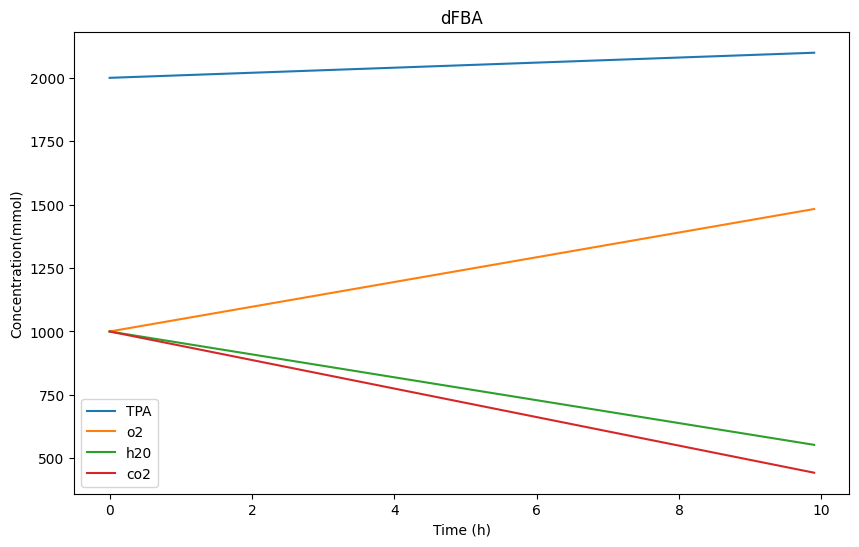

In [16]:
# 设置初始介质成分
initial_carbon = 2000  # mmol
carbon_source = 'EX_tpa_e'  # 碳源 (TPA)
other_metabolites = {
    'EX_ca2_e': 1000, 
    'EX_cl_e': 1000, 
    'EX_cobalt2_e': 1000, 
    'EX_cu2_e': 1000,
    'EX_fe2_e': 1000,
    'EX_glc_D_e': 10,
    'EX_h_e': 1000,
    'EX_k_e': 1000,
    'EX_mg2_e': 1000,
    'EX_mn2_e': 1000,
    'EX_mobd_e': 1000,
    'EX_na1_e': 1000,
    'EX_nh4_e': 1000,
    'EX_ni2_e': 1000,
    'EX_o2_e': 1000,
    'EX_pi_e': 1000,
    'EX_so4_e': 1000,
    'EX_zn2_e': 1000,
    'EX_h2o_e': 1000,
    'EX_co2_e': 1000,
}

# 检查模型中是否有相应反应
if carbon_source not in model.reactions:
    raise ValueError(f"模型中没有碳源 '{carbon_source}' 对应的反应")
    
# 确保 TPA 是被摄取的
model.reactions.get_by_id('EX_tpa_e').lower_bound = -10  # 负值表示摄取
model.reactions.get_by_id('EX_tpa_e').upper_bound = 0    # 不允许产生

# 确保 CO2 是被排放的
model.reactions.get_by_id('EX_co2_e').lower_bound = 0    # 不允许摄取
model.reactions.get_by_id('EX_co2_e').upper_bound = 1000 # 正值表示排放

# 设置时间步长和模拟时间
time_step = 0.1  # 小时
max_time = 10  # 最大模拟时间 (小时)
time_points = np.arange(0, max_time, time_step)

# 存储介质浓度用于绘图
concentration_data = {'time': [], 'carbon': [], 'O2': [], 'H2O': [], 'CO2': []}

# 初始化浓度
current_carbon = initial_carbon
current_metabolites = other_metabolites.copy()

for time in time_points:
    # 记录当前时间和浓度
    concentration_data['time'].append(time)
    concentration_data['carbon'].append(current_carbon)
    concentration_data['O2'].append(current_metabolites['EX_o2_e'])
    concentration_data['H2O'].append(current_metabolites['EX_h2o_e'])
    concentration_data['CO2'].append(current_metabolites['EX_co2_e'])
    
    # 检查碳源是否已耗尽
    if current_carbon < 0.01:
        print(f"碳源接近耗尽，模拟结束在时间 {time:.2f} 小时.")
        break

    # 设置模型中的培养基约束
    max_carbon_uptake = -10  # 设置最大碳源摄取速率
    model.reactions.get_by_id(carbon_source).lower_bound = max_carbon_uptake
    for metabolite, amount in current_metabolites.items():
        if metabolite in model.reactions:
            model.reactions.get_by_id(metabolite).lower_bound = -amount / time_step

    # 优化模型，计算通量
    solution = model.optimize()

    # 提取通量值，更新培养基浓度
    fluxes = solution.fluxes
    if carbon_source in fluxes:
        carbon_flux = fluxes[carbon_source]
        current_carbon -= carbon_flux * time_step

    # 更新其他代谢物的浓度
    for metabolite in current_metabolites:
        if metabolite in fluxes:
            current_metabolites[metabolite] -= fluxes[metabolite] * time_step

    # 检查是否有代谢物浓度为负，表示耗尽
    if any(v < 0 for v in current_metabolites.values()):
        print(f"其他代谢物耗尽，模拟结束在时间 {time:.2f} 小时.")
        break

# 绘制结果
plt.figure(figsize=(10, 6))
plt.plot(concentration_data['time'], concentration_data['carbon'], label="TPA")
plt.plot(concentration_data['time'], concentration_data['O2'], label="o2")
plt.plot(concentration_data['time'], concentration_data['H2O'], label="h20")
plt.plot(concentration_data['time'], concentration_data['CO2'], label="co2")
plt.xlabel('Time (h)')
plt.ylabel('Concentration(mmol)')
plt.legend()
plt.title('dFBA')
plt.show()


In [17]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.006271,0,0.00%
cl_e,EX_cl_e,0.006271,0,0.00%
cobalt2_e,EX_cobalt2_e,0.004511,0,0.00%
cu2_e,EX_cu2_e,0.00418,0,0.00%
fe2_e,EX_fe2_e,0.0218,0,0.00%
glc__D_e,EX_glc__D_e,6,6,31.03%
h_e,EX_h_e,5.472,0,0.00%
k_e,EX_k_e,0.2352,0,0.00%
mg2_e,EX_mg2_e,0.01045,0,0.00%
mn2_e,EX_mn2_e,0.00418,0,0.00%


In [5]:
# 设置初始介质成分
initial_carbon = 200  # mmol
carbon_source = 'tpa_e'  # 碳源 (TPA)
other_metabolites = {
    'ca2_e': 1, 
    'cl_e': 1, 
    'cobalt2_e': 1, 
    'cu2_e': 1,
    'fe2_e': 1,
    'glc_D_e': 0,
    'h_e': 10,
    'k_e': 1,
    'mg2_e': 1,
    'mn2_e': 1,
    'mobd_e': 1,
    'na1_e': 1,
    'nh4_e': 10,
    'ni2_e': 1,
    'o2_e': 100,
    'pi_e': 1,
    'so4_e': 1,
    'zn2_e': 1,
    'pqqA_kt_c': 1,
    'h2o_e': 100,
    'co2_e': 1,
    
}  # 其他代谢物 (氧气、水、二氧化碳)

# 设置时间步长和模拟时间
time_step = 0.1  # 小时
max_time = 10  # 最大模拟时间 (小时)
time_points = np.arange(0, max_time, time_step)

# 存储介质浓度用于绘图
concentration_data = {'time': [], 'carbon': [], 'O2': [], 'H2O': [], 'CO2': []}

# 初始化浓度
current_carbon = initial_carbon
current_metabolites = other_metabolites.copy()

for time in time_points:
    # 记录当前时间和浓度
    concentration_data['time'].append(time)
    concentration_data['carbon'].append(current_carbon)
    concentration_data['O2'].append(current_metabolites['o2_e'])
    concentration_data['H2O'].append(current_metabolites['h2o_e'])
    concentration_data['CO2'].append(current_metabolites['co2_e'])
    
    # 检查碳源是否已耗尽
    if current_carbon <= 0:
        print(f"碳源耗尽，模拟结束在时间 {time:.2f} 小时.")
        break

    # 设置模型中的培养基约束
    model.reactions.get_by_id(carbon_source).lower_bound = -current_carbon / time_step
    for metabolite, amount in current_metabolites.items():
        model.reactions.get_by_id(metabolite).lower_bound = -amount / time_step

    # 优化模型，计算通量
    solution = model.optimize()

    # 提取通量值，更新培养基浓度
    fluxes = solution.fluxes
    carbon_flux = fluxes[carbon_source]
    current_carbon -= carbon_flux * time_step

    # 更新其他代谢物的浓度
    for metabolite in current_metabolites:
        current_metabolites[metabolite] -= fluxes[metabolite] * time_step

    # 检查是否有代谢物浓度为负，表示耗尽
    if any(v < 0 for v in current_metabolites.values()):
        print(f"其他代谢物耗尽，模拟结束在时间 {time:.2f} 小时.")
        break

# 绘制结果
plt.figure(figsize=(10, 6))
plt.plot(concentration_data['time'], concentration_data['carbon'], label="碳源")
plt.plot(concentration_data['time'], concentration_data['O2'], label="氧气")
plt.plot(concentration_data['time'], concentration_data['H2O'], label="水")
plt.plot(concentration_data['time'], concentration_data['CO2'], label="二氧化碳")
plt.xlabel('时间 (小时)')
plt.ylabel('浓度 (mmol)')
plt.legend()
plt.title('dFBA 模拟 - 培养基浓度随时间变化')
plt.show()


KeyError: 'tpa_e'